<a href="https://colab.research.google.com/github/ese-msc-2022/acds-moonshot-xenophanes/blob/main/yolo_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Jan 31 02:06:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%bash
pip install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.0 MB/s eta 0:00:00


In [5]:
# import the modules
import os
from os import listdir
import shutil
import csv

import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from sklearn.model_selection import train_test_split



In [6]:
print(os.getcwd())
dir = '/content/drive/MyDrive/Colab Notebooks/Olya'
yolo_dir = f'{dir}/yolov5'
data_dir = f'{dir}/data'
dataset_dir = f'{dir}/dataset'

/content


In [14]:
#cleaniing

test = os.listdir(os.path.join(data_dir, 'labels', ))
for item in test:
    if item.endswith(".txt"):
      os.remove(os.path.join(data_dir, 'labels', item))

test = os.listdir(os.path.join(dataset_dir, 'labels', 'train'))
for item in test:
    os.remove(os.path.join(dataset_dir, 'labels', 'train', item))
    
test = os.listdir(os.path.join(dataset_dir, 'images', 'train'))
for item in test:    
    os.remove(os.path.join(dataset_dir, 'images', 'train', item))

test = os.listdir(os.path.join(dataset_dir, 'labels', 'val'))
for item in test:
    os.remove(os.path.join(dataset_dir, 'labels', 'val', item))

test = os.listdir(os.path.join(dataset_dir, 'images', 'val'))
for item in test:
    os.remove(os.path.join(dataset_dir, 'images', 'val', item))

In [15]:
#splitting the dataset
random.seed(41)

# Read images and annotations
images = os.listdir(f'{data_dir}/images/')
labels = os.listdir(f'{data_dir}/labels/')
images.sort()
labels.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.3, random_state = 1)

for _ in ['train','val']:
  for __ in ['images','labels']:
    print(globals()[f"{_}_{__}"])
    for i in globals()[f"{_}_{__}"]:
        
      print((f'Copying: {data_dir}/{__}/{i} to {dataset_dir}/{__}/{_}/{i}'))   
      shutil.copyfile(f'{data_dir}/{__}/{i}', f'{dataset_dir}/{__}/{_}/{i}')
      



['amenthes_41_31.png', 'arabia_12_20.png', 'amazonis_10_2.png', 'syrtismajor_47_11.png', 'coprates_29_9.png', 'margaritifersinus_11_11.png', 'tharsis_34_35.png', 'arabia_10_41.png', 'oxiapalus_26_37.png', 'lunaepalus_22_10.png', 'margaritifersinus_35_11.png', 'margaritifersinus_23_11.png', 'tharsis_27_22.png', 'amazonis_42_19.png', 'maretyrrhenum_35_8.png', 'phoenicislacus_20_32.png', 'margaritifersinus_17_34.png', 'phoenicislacus_52_2.png', 'phoenicislacus_13_9.png', 'aeolis_54_0.png', 'elysium_30_29.png', 'phoenicislacus_11_18.png', 'coprates_15_10.png', 'phoenicislacus_23_30.png', 'tharsis_33_7.png', 'phoenicislacus_63_9.png', 'sinussabaeus_19_4.png', 'coprates_31_12.png', 'elysium_52_30.png', 'elysium_35_41.png', 'amazonis_28_35.png', 'phoenicislacus_62_6.png', 'tharsis_35_6.png', 'margaritifersinus_39_5.png', 'elysium_63_29.png', 'tharsis_24_27.png', 'arabia_18_1.png', 'elysium_56_32.png', 'amenthes_52_0.png', 'lunaepalus_15_26.png', 'margaritifersinus_26_22.png', 'iapygia_61_37.p

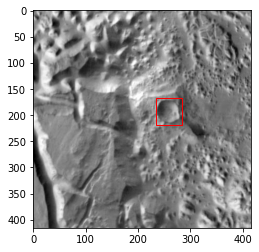

In [17]:
#plot example test image with lable
#Load the image
img = f'{dataset_dir}/images/train/{train_images[10]}'
#img = f'{dataset_dir}/images/train/amazonis_14_11.png'#{train_images[0]}'

_ = Image.open(img)
fig, ax = plt.subplots()
ax.imshow(_, cmap='gray')

#load the lable
lbl = img.replace("images", "labels").replace("png", "csv")
my_coords = np.genfromtxt(lbl, delimiter=',')

w,h = _.size
if my_coords.ndim == 1:
  rect = patches.Rectangle((my_coords[0]*w-(my_coords[2]*w/2), my_coords[1]*h-(my_coords[3]*h/2)), my_coords[2]*w, my_coords[3]*h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
else:  
  rect={}
  for i in range(my_coords.ndim):
    rect[i] = patches.Rectangle((my_coords[i][0]*w-(my_coords[i][2]*w/2), my_coords[i][1]*h-(my_coords[i][3]*h/2)), my_coords[i][2]*w, my_coords[i][3]*h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect[i])

plt.show()

  



In [20]:
# we need to convert csv to txt for lables
for _ in ['train','val']:
  print(globals()[f"{_}_labels"])
  for i in globals()[f"{_}_labels"]:
    csv_file = f'{dataset_dir}/labels/{_}/{i}'
    txt_file = f'{dataset_dir}/labels/{_}/{i}'.replace('csv','txt') 
    print((f'Converting: {csv_file} to {txt_file}'))
    if os.path.exists(txt_file):
      os.remove(txt_file)
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write("0 "+" ".join(row)+'\n') for row in csv.reader(my_input_file)] 
        my_output_file.close()
    os.remove(csv_file) 

['amenthes_41_31.csv', 'arabia_12_20.csv', 'amazonis_10_2.csv', 'syrtismajor_47_11.csv', 'coprates_29_9.csv', 'margaritifersinus_11_11.csv', 'tharsis_34_35.csv', 'arabia_10_41.csv', 'oxiapalus_26_37.csv', 'lunaepalus_22_10.csv', 'margaritifersinus_35_11.csv', 'margaritifersinus_23_11.csv', 'tharsis_27_22.csv', 'amazonis_42_19.csv', 'maretyrrhenum_35_8.csv', 'phoenicislacus_20_32.csv', 'margaritifersinus_17_34.csv', 'phoenicislacus_52_2.csv', 'phoenicislacus_13_9.csv', 'aeolis_54_0.csv', 'elysium_30_29.csv', 'phoenicislacus_11_18.csv', 'coprates_15_10.csv', 'phoenicislacus_23_30.csv', 'tharsis_33_7.csv', 'phoenicislacus_63_9.csv', 'sinussabaeus_19_4.csv', 'coprates_31_12.csv', 'elysium_52_30.csv', 'elysium_35_41.csv', 'amazonis_28_35.csv', 'phoenicislacus_62_6.csv', 'tharsis_35_6.csv', 'margaritifersinus_39_5.csv', 'elysium_63_29.csv', 'tharsis_24_27.csv', 'arabia_18_1.csv', 'elysium_56_32.csv', 'amenthes_52_0.csv', 'lunaepalus_15_26.csv', 'margaritifersinus_26_22.csv', 'iapygia_61_37.c

In [21]:

!python '{yolo_dir}/train.py' --img 416 --cfg yolov5s.yaml --hyp moon_hyp_params.yaml --batch 32 --epochs 100 --data moon.yaml --weights yolov5s.pt --workers 24 --name yolo_moons


train: weights=yolov5s.pt, cfg=yolov5s.yaml, data=moon.yaml, hyp=moon_hyp_params.yaml, epochs=100, batch_size=32, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=drive/MyDrive/Colab Notebooks/Olya/yolov5/runs/train, name=yolo_moons, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
Command 'git fetch origin' timed out after 5 seconds
fatal: cannot change to '/content/drive/MyDrive/Colab': No such file or directory
YOLOv5 🚀 2023-1-30 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls

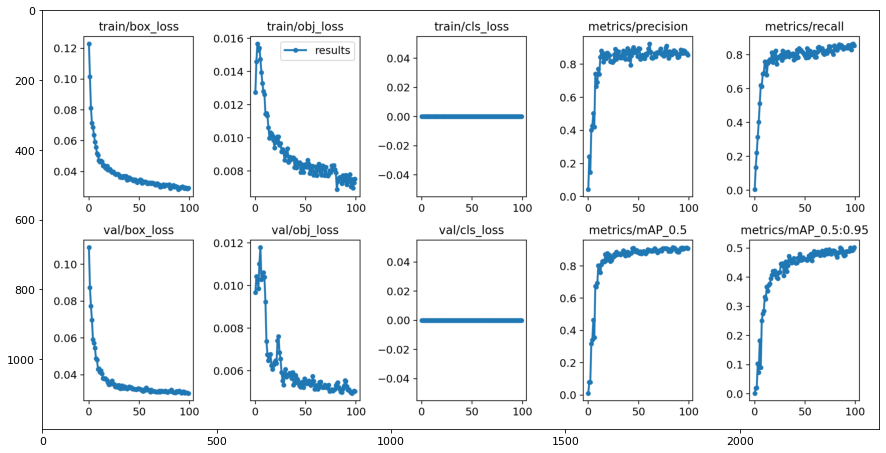

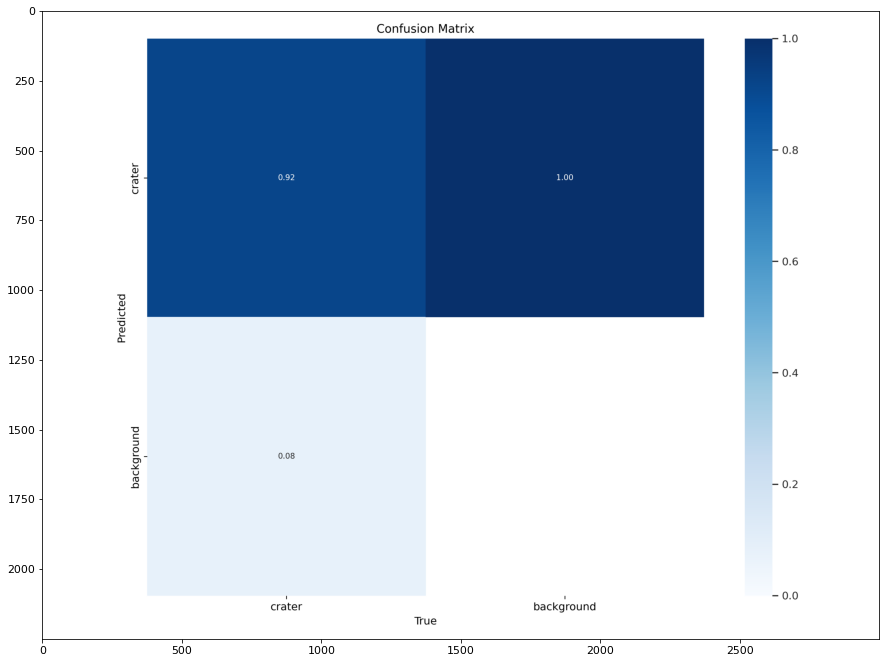

In [50]:
#results
img = '/content/drive/MyDrive/Colab Notebooks/Olya/yolov5/runs/train/yolo_moons4'
_ = Image.open(os.path.join(img, 'results.png', ))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(_)

_ = Image.open(os.path.join(img, 'confusion_matrix.png', ))
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(_)


In [43]:
# importing sys
import sys
 
# adding Folder_2/subfolder to the system path
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/Olya/yolov5/utils')
 
from utils.plots import plot_results
plot_results('/content/drive/MyDrive/Colab Notebooks/Olya/yolov5/runs/train/yolo_moons4/results.csv')